In [33]:
import numpy as np
import matplotlib.pyplot as plt
import quadrotor

In [34]:
dt = quadrotor.DELTA_T
m = quadrotor.MASS
g = quadrotor.GRAVITY
r = quadrotor.LENGTH
I = quadrotor.INERTIA

In [35]:
Q1 = np.diag([10,10,10,10,1000,10])
Q2 = np.diag([10,10,10,10,10,10])
R_ = (np.identity(2))*1
z_star = np.array([[1.5,3],[0,0],[6,0],[0,0],[(np.pi),2*(np.pi)], [0,0]])
u_star = np.array([[(m*g)/2], [(m*g)/2]])

In [36]:
def get_linearization(z,u):
  x = z[0]
  vx = z[1]
  y = z[2]
  vy = z[3]
  theta = z[4]
  omega = z[5]

  u1 = u[0]
  u2 = u[1]

  dfdx = np.array([[1,dt,0,0,0,0], [0,1,0,0,-(dt*(u1+u2)*np.cos(theta))/m,0], [0,0,1,dt,0,0],
                   [0,0,0,1,-(dt*(u1+u2)*np.sin(theta))/m,0], [0,0,0,0,1,dt], [0,0,0,0,0,1]])
  
  dfdu = np.array([[0,0], [(-dt*np.sin(theta))/m, (-dt*np.sin(theta))/m], [0,0],
                   [(dt*np.cos(theta))/m, (dt*np.cos(theta))/m], [0,0], [(dt*r/I), -(dt*r/I)]])
  
  A = dfdx
  B = dfdu

  return A,B

def get_A_B(xstar, ustar):
  A_list = []
  B_list = []
  for i in range(1000):
    A, B = get_linearization(xstar[:,i],ustar[:,i])
    A_list.append(A)
    B_list.append(B)
  return A_list, B_list

In [37]:
def compute_cost(z, u, horizon_length):
  cost = 0
  z_5 = np.array([[1.5],[0.],[6.0],[0.],[(np.pi)/2],[0.]])
  z_5 = z_5.reshape((6,1))
  z_10 = np.array([[3.],[0.],[0.],[0.],[2*(np.pi)],[0.]])
  z_10 = z_10.reshape((6,1))
  u_des = np.array([[m*g/2],[m*g/2]])
  u_des = u_des.reshape((2,1))
  for n in range(horizon_length+1):
    if n>= 0 and n<=400:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn_T = zn.transpose()
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      cost = 0.5*(zn_T@Q1@zn + un_T@R_@un) + cost
    elif n>400 and n<=501:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      zn = zn-z_5
      zn_T = zn.transpose()
      cost = 0.5*(zn_T@Q2@zn + un_T@R_@un) + cost
    elif n>501 and n<1000:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn = zn-z_10
      zn_T = zn.transpose()
      un = u[:,n]
      un = un.reshape((2,1))
      un = un - u_des
      un_T = un.transpose()
      cost = 0.5*(zn_T@Q2@zn + un_T@R_@un) + cost
    else:
      zn = z[:,n]
      zn = zn.reshape((6,1))
      zn = zn-z_10
      zn_T = zn.transpose()
      cost = 0.5*(zn_T@Q2@zn) + cost
  cost = cost[0][0]
  return cost

In [38]:
#get quadratic approximation cost
def get_quadratic_approximation_cost(z, u, horizon_length):
  r,q=[],[]
  Q,R=[],[]
  for i in range(horizon_length):
    if i<=400:

      q1=Q1@((z[:,i].reshape(6,1)))
      r1=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r1)
      q.append(q1)
      Q.append(Q1)
    
    elif i>400 and i<=501:
      q2=Q2@((z[:,i].reshape(6,1))-(z_star[:,0].reshape(6,1)))
      r2=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r2)
      q.append(q2)
      Q.append(Q2)
      
    else:
      q3=Q2@((z[:,i].reshape(6,1))-(z_star[:,1].reshape(6,1)))
      r3=2*R_@((u[:,i].reshape(2,1)-u_star))
      r.append(r3)
      q.append(q3)
      Q.append(Q2)
      
    R.append(R_)

  Q.append(Q2)
  q_l=-Q2@(z_star[:,0])
  q.append(q_l.reshape(6,1))
  
  
  return r,q,Q,R

In [39]:
def solve_LQR_trajectory(A_list, B_list, Q_list, R_list, q_list, r_list, N):
       
        P_1 = Q_list[N]
        p_1 = q_list[N]
        
        K_gains = []
        k_feedforward = []
        
        for i in range(N-1,-1,-1):
            
            #Added these since A and B are not same
            A = A_list[i]
            B = B_list[i]
            B_T = B.transpose()
            A_T = A.transpose()
        
            Q = Q_list[i]
            R = R_list[i]
            q = q_list[i]
            r = r_list[i]
            q = q.reshape((6,1))
            r = r.reshape((2,1))
            term = R + B_T@P_1@B
            inv_term = np.linalg.inv(term)

            Kn = -inv_term@B_T@P_1@A
            K_gains.insert(0,Kn)
            
            P = Q + A_T@P_1@A + A_T@P_1@B@Kn
            rn_term = B_T@p_1 + r
            kn = -inv_term@rn_term
            temp = kn.reshape((kn.shape[0],1))

            k_feedforward.insert(0, temp)
        
            p = q + A_T@p_1 + A_T@P_1@B@kn
            
            P_1 = P
            p_1 = p
        
        return K_gains, k_feedforward

In [40]:
def calculate_state(z_star,k_t,K_t,alpha,u_star_t,N):
  u_t=np.zeros([2,N])
  z_t=np.zeros([6,N+1])

  for n in range(N):
    u_o=u_star_t[:,n].reshape(2,1)+K_t[n].dot(z_t[:,n].reshape(6,1)-z_star[:,n].reshape(6,1))+alpha*k_t[n]
    z_t[:,n+1]= quadrotor.get_next_state(z_t[:,n],u_o)
    u_t[:,n]=u_o.reshape(2,)

  return z_t,u_t

In [41]:
#Iterative_LQR_loop
horizon_length = 1000
ustar = np.zeros([2, horizon_length])
zstar = np.zeros([6, horizon_length+1])
alpha = 1

#Loop is ran 50 times since the cost is converging
for i in range(50):
  for n in range(horizon_length):
    z_next = quadrotor.get_next_state(zstar[:,n],ustar[:,n])
    zstar[:,n+1] = z_next

  A_list,B_list = get_A_B(zstar,ustar)

  r_list,q_list,Q_list,R_list = get_quadratic_approximation_cost(zstar,ustar,horizon_length)
  
  K_gain,k_feedforward = solve_LQR_trajectory(A_list,B_list,Q_list,R_list,q_list,r_list,horizon_length)

  prev_cost = compute_cost(zstar,ustar,horizon_length)

  z_N,u_N = calculate_state(zstar,k_feedforward,K_gain,alpha,ustar,horizon_length)

  curr_cost = compute_cost(z_N,u_N,horizon_length)
  print("cost value is:", curr_cost)

  if curr_cost<prev_cost:
    prev_cost = curr_cost
  else:
    print("decreasing alpha")
    alpha = alpha/2
  
  ustar=u_N

  if alpha<0.1:
    break

cost value is: 3763072673681.9624
decreasing alpha
cost value is: 949481321659.1055
cost value is: 239391633625.63583
cost value is: 60433382022.401474
cost value is: 15276210336.141766
cost value is: 3864496542.7648983
cost value is: 976303162.7148304
cost value is: 247015355.27527416
cost value is: 62809826.67619457
cost value is: 16048992.188988293
cost value is: 4152280.2437309246
cost value is: 1106192.3617522675
cost value is: 325723.11964580184
cost value is: 124086.94389784527
cost value is: 71074.35726871825
cost value is: 56761.10379748325
cost value is: 52097.503058833696
cost value is: 49333.70511919801
cost value is: 45960.3649505104
cost value is: 40826.20941817008
cost value is: 35806.169538825554
cost value is: 33464.62477538756
cost value is: 32861.827562063714
cost value is: 32701.155566185305
cost value is: 32649.557565055613
cost value is: 32626.487024433853
cost value is: 32612.102934865918
cost value is: 32601.22228087227
cost value is: 32592.303272911406
cost val

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABSOW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA1pZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0b
M34HfeIBLw2NULVMqhzqmkC+X53Wgy7Lw2o5tSedGqtnOugH52lIi7P24behEG6Rnkk+WdTQf4eW
uPgCxivMZdxHEjn7VJLwZY+eI9HwO3plS7KgxBP2PAIULur9c1ztvyHTsIHpQ7AWk0MUEIPegRQe
mleg2OVFv447q+4/TWiy/+ZSzz1L5zehMVNsU5uy76TKZxI95ywPynYwwhdU/2fM2AnaYgwOfdkf
69A3REFLf6rK5fLs8TBpH4sqRqPKnDcIE+bSBngHwUCUcKJ4CnZV2Fc2GCOX6fHviA6j/zly2rMM
HUeiwnRJv2v0wCxmVpi0bb9R5cpW87efbtbkapNwAAADAACkO+cZ0stP/OH3eYLy91u40xzbOE20
ByD69s9+DABmn3QWsHL0mPtcVAIzZb7Vh3hwyFyO3O8PEAaWQTIy7/JSRilDyCxY9myTS2XjsHRr
cLZDzeBzHsYgZm1qK0pt5fPalV6EqlIAD4Nb74uRzyrU0QQ+shHMVOqZ2a4jMH+iG/s1HNTN7oNG
1fskfeaXj091zsRKRrFeX+LmnSVB8Bv/QuT0PhVVcA6zeJm8ZqTk+eNoBoluOyRQDTqH22p2lm1/
SjZ4oe1FcWSOeVSMN+4o06DECSjeyNYEOtk5lgUt8BXMYEapBdW/s0kxB2JPR6P3XiULFPFlt1+q
oRH6aHndVKuz43brCfMtXtD55d6r+n0TQAKlWrm5k6ywd4AzVe/zF6jmfcYCEggAAAMBawBz2N71
HqgtzgiF3JruEPq9thVHK3CrcUXF+w/UWorSk1yYuxQt0AKVJGioHNCM38+eYrFyTfSiqhhDTWCb
GWpFqvYqhKRZjv+spYjd35dzSfnQ+WM6ACshKLrxSGKCJFp/vEkxtFp+ZFVTE57Kf/0AGr7ZGhoa
2dE/70ZJVCVWjdPo33K6wwqB50p6/LnAiODhji8zOi159LcpOsO4SQwJ7Z6VUiynC1dUfAbICm/J
3FlJO7jz3hQRgrTdOFwqMUBN7IoK1rlElb1sVwSP7Lwf1ip6rpfh2XhA/hVksM7X5GarXjaJpqMo
ZEEroJ/JaHDTHTL/ymk8ZVTNKtcAHQAAC4AW3YId42lge1obFYy66jPP4mzhlM8elDw8lKYc6WC7
f/zVUlPShpjgBtNZ/6vc9WoIFJsE9VhCRDpfvmEQFQ+euOzuR/O2lrVGjbnGH6Ddg5OQFP+pIfT+
ji7HWMGXE3PZhIwh3q0T0knCqX1m6AdZMMxQJBlGqW4TU2t//lwf1Bae/FmKhOKH0GgnceGFIaDx
jCbUGz43K9JRhaMiMN0ONmzxHkfLGZmP1LSo1og2q/9iojFqWsYA6X65zcUvTAH1q377PaO0zYsn
h6mEbI9t0RWSC3jSfu8/9l6M5ePBbdoGaZ8kjdSz2LX+DqznP4JeV9beBUqwQtrTUtKmddBzivdH
3dKF1wAAAwATxdrxM2XnXb/vWDlEU/D6RENqFU2pPYworBOe6zmzemp4q1LyGgC1mcAK6Oqe+fpX
/2ZC2ivyq7p/j2Xqb6nj+6mWKjmYvVBW9VixGSVALEa8s7NI8r2nTB++zx1NT9TbxiKstZJpiwo1
ZtX/q/5Uk7ORGS5+YqzIfUgRAQByctKP9lrBVMktN5wb1TqsaGc2/IEgGVOJv8iXJHINYOtMOG/6
gAY3Y41MqbGA2g2m3ZcfpnXFuFWDoc8ULa3nMh7J7bZE0OF3iOuslKx0OK3WO30+PbRWSM9bwpqe
IiT/kX6umRYeX6zO2paDtfAIyQVCDAQxBuWU3vmbBtLRxqh7cr78itvg3Wi2p2zDFfzfC7IIRKRX
cxd+x3LDV9x4qEl0BlCUnTYF6ccCggsKfC5jcgpvxs3AkIlGlWiRGBo1yT5lHs78+xfi/r1/8dG/
nXcYHR/7p5DfGyFlNSOi4cTmxZp8u9MYb+ZJYQH5sKSM/vuqzVWcw49cbdLyQ2fy2+LU3ZVauz79
RcEOr6zbHIk3/9bVOK6gBM7wQhLBD4FZuY0VjfTZ2eHcLX+cc7qD0VqM/1I4FkGLWU3R8pQVOg+4
2g12fSgUGnqwHEVydE2mqkBpGaBksvIAA5QAAwgNSKo+KrrWoJDOJ+IA6qEyIyrPuoDbxbxHrspI
OE9xeeXxlpG9lIhSWwztIN3Ju5sbCHHtaOwRthVRRJAHZb6MNUAWpancs7/gaN2HaQRYKBBPEkGx
8kLYLqHFRRbHmos/Nk2C9qe5MDlDdQ7G43hsZMQA0oeFzgoB9Eep9Wkcpv7S8AKspnSm+9ANh/+i
xqOaMfJaFeWE9jYTdmO80SaXNC3ElelOa5kAiLgyXClBrra4Q///67K/zhPoQQ/5u7NWT6r/u39L
D9wrHVmBbEFjl5//rc6Xe2TT0+YaP1nDMn2RQ/+2FZ/dSzRCMyymXx4/39h0QP3lyadKuMBVyjuK
KiEb6Dau/zndVgwVCvP8DJ+dfTNVqFp1ELIarh563B+mv0Q+BO2+75AOK6CLCKdsxpQXUqQ0aLwL
6dJomPag49C5KWSCol0/EHZnidJanlyJaNKazXctDtM5CdSNrJbFc+2/hQMUyC39x/U/qQF14AvC
oUC23gG2cP6Gm911lqWf/ylBSbaoPbVuBmpyRqanf9AM8BYGSixhbeVv/2mDwwtlNr9LUaRH3LXx
shZTUjn9VSPcnDvLoPydOcwu7Q/bnh5w7AfDTKq87DtqvDZdNDkKzEzgDeyGAsRXSgegxOunoGZk
/GKdFDUVf4ZDzIc6goE46xKZdTYQAM4mziq5Z5NAFgIR9R3NIsYRoJ27+WMs4LVitMRxU9HfVjao
+dTOI53flJAKZTjdQRFm4

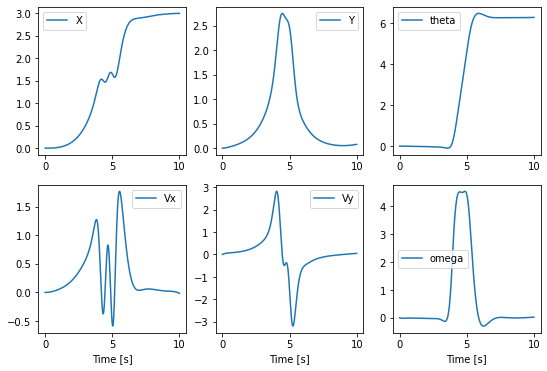

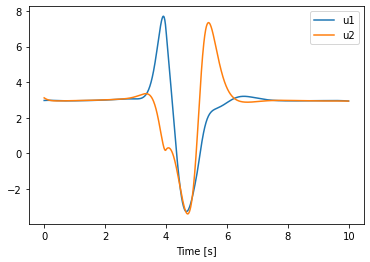

In [42]:
state = zstar
u = ustar
t = np.zeros([horizon_length+1,])
for i in range(horizon_length):
  t[i+1] = t[i] + dt

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# now we can also create an animation
quadrotor.animate_robot(state, u)